In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from image_manipulation import *

2022-11-18 10:23:12.523510: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [18]:
# GPU check
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
# Load data
samples = np.load('rank_samples.npy')
labels = np.load('rank_labels.npy')
print(samples.shape)
print(labels.shape)

(4160, 720, 960)
(4160,)


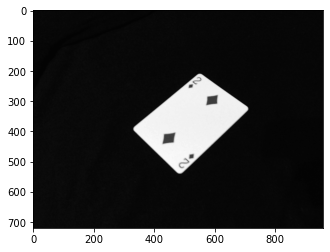

In [20]:
# Visualize a sample
plt.imshow(samples[0], cmap='gray')

In [21]:
def prosess_samples(samples):
    """
    Preprocess samples for training
    """

    processed = []

    for i, sample in enumerate(samples):
        white_mask = create_white_mask(sample)
        contour = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
        corners = find_contour_corners(contour)
        if corners is None:
            print(f'sample skipped at index: {i}')
            continue
        inverted = 255 - sample
        birds_eye = create_birds_eye_view(inverted, corners, (500, 700))
        rank_crop = birds_eye[0:110, 0:60] # 60x110
        processed.append(rank_crop)

    return np.array(processed)

In [22]:
# Preprocess samples
samples = prosess_samples(samples)

In [23]:
# Check processed samples
print(samples.shape)

(4160, 110, 60)


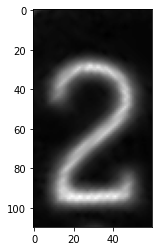

In [24]:
# Visualize a sample
plt.imshow(samples[0], cmap='gray')

In [25]:
# Shuffle data
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)
samples = samples[indices]
labels = labels[indices]

In [26]:
# Split data
ratio = 0.9
split = int(samples.shape[0] * ratio)
x_train = samples[:split]
y_train = labels[:split]
x_test = samples[split:]
y_test = labels[split:]
print(len(x_train), len(x_test))

3744 416


In [27]:
# Choose layers
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(110, 60, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(13, activation='softmax')
])

In [28]:
# Choose loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [29]:
# Choose optimizer
opt = 'adam'

In [30]:
# Compile model
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

In [31]:
# Train model
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
117/117 [==============================] - 0s 1ms/step - loss: 18.2234 - accuracy: 0.4904
Epoch 2/3
117/117 [==============================] - 0s 1ms/step - loss: 0.9172 - accuracy: 0.7780
Epoch 3/3
117/117 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.8189


In [32]:
# Evaluate model
model.evaluate(x_test, y_test, verbose=2)

13/13 - 0s - loss: 0.6098 - accuracy: 0.8534 - 72ms/epoch - 6ms/step


[0.609817624092102, 0.8533653616905212]

In [33]:
# Save model
model.save('rank_model')

INFO:tensorflow:Assets written to: rank_model/assets


INFO:tensorflow:Assets written to: rank_model/assets
